In [1]:
import sys
sys.path.append('../src/')
from utils import *
torch.manual_seed(42) 
plt.rc('axes.formatter',use_mathtext=True)

In [2]:
# load data
X = np.load('../test/X_meshR.npy')
Z = np.load('../test/Z_meshZ.npy')
PhiT = np.load('../test/PhiT.npy')
m = len(PhiT)
dataset = torch.tensor(PhiT).unsqueeze(1).float()
# split to train and test
train_data, test_data = random_split(dataset, [int(m*0.8), m-int(m*0.8)])
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=False) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

## initialize FTL model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('current device:', device)
p_encoder = '../model/FTL_trained_encoder'
p_decoder = '../model/FTL_trained_decoder'
encoder, decoder = load_trained_network(p_encoder, p_decoder, device)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

current device: cuda



 EPOCH 1/200 	 train loss 0.0242597796022892

 EPOCH 1/200 	 val loss 0.011441318318247795


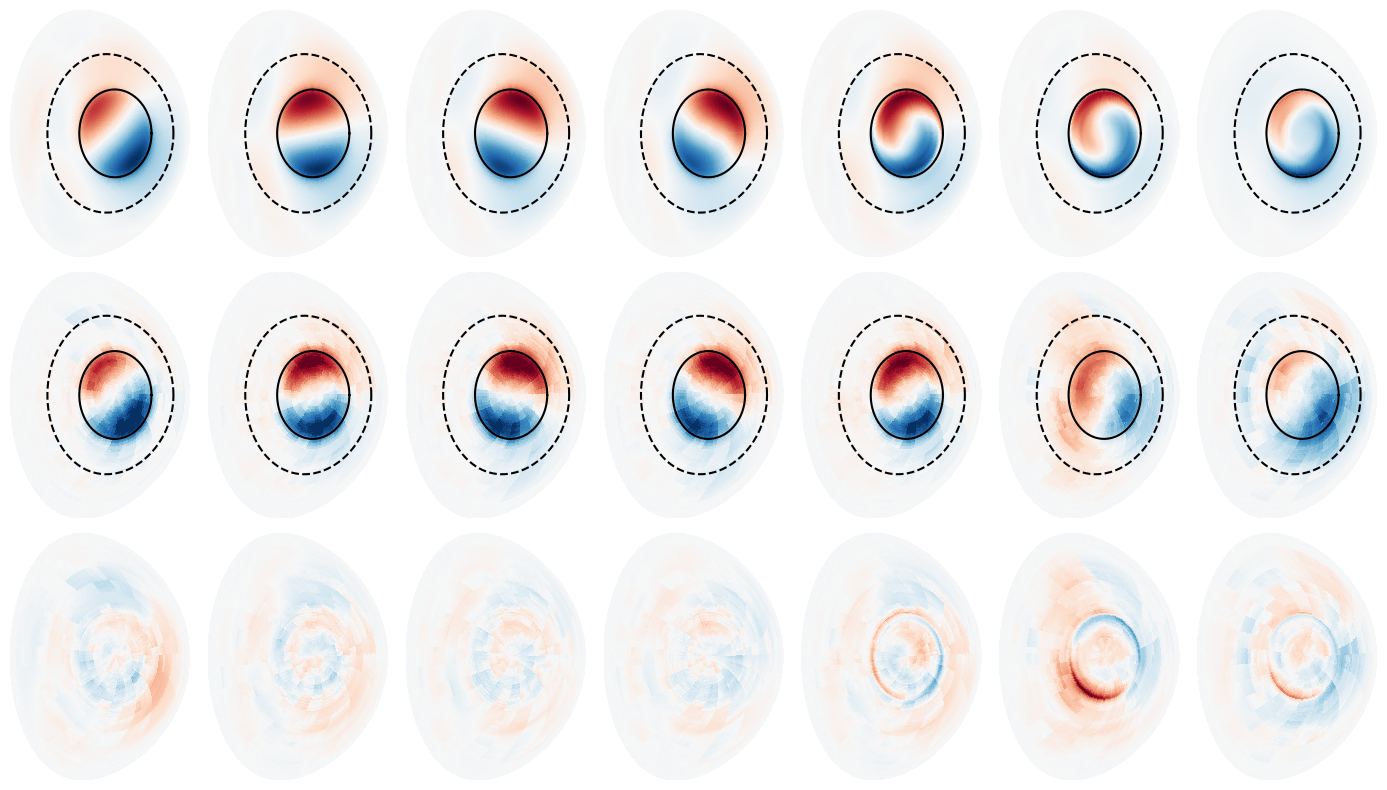


 EPOCH 2/200 	 train loss 0.012297330424189568

 EPOCH 2/200 	 val loss 0.009734106250107288

 EPOCH 3/200 	 train loss 0.009120803326368332

 EPOCH 3/200 	 val loss 0.009319626726210117

 EPOCH 4/200 	 train loss 0.007830129936337471

 EPOCH 4/200 	 val loss 0.00906350463628769

 EPOCH 5/200 	 train loss 0.006846385542303324

 EPOCH 5/200 	 val loss 0.009040923789143562

 EPOCH 6/200 	 train loss 0.00618334487080574

 EPOCH 6/200 	 val loss 0.008896883577108383

 EPOCH 7/200 	 train loss 0.005730582866817713

 EPOCH 7/200 	 val loss 0.008410424925386906

 EPOCH 8/200 	 train loss 0.005385659635066986

 EPOCH 8/200 	 val loss 0.007781422697007656

 EPOCH 9/200 	 train loss 0.00507676787674427

 EPOCH 9/200 	 val loss 0.007151538506150246

 EPOCH 10/200 	 train loss 0.004789815284311771

 EPOCH 10/200 	 val loss 0.006584680639207363

 EPOCH 11/200 	 train loss 0.004565241746604443

 EPOCH 11/200 	 val loss 0.006023413501679897

 EPOCH 12/200 	 train loss 0.0043639009818434715

 EPOCH 1

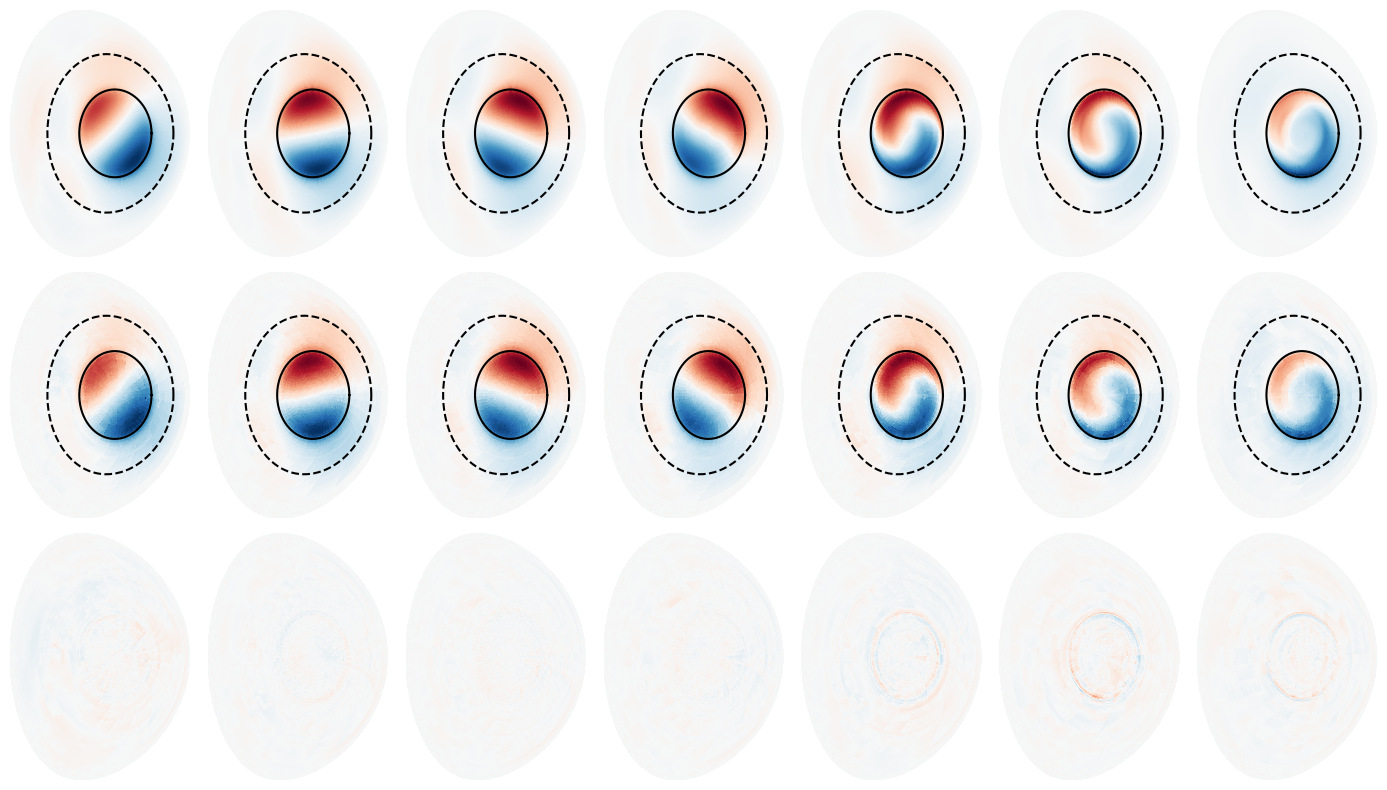


 EPOCH 102/200 	 train loss 0.0008181019220501184

 EPOCH 102/200 	 val loss 0.0012116975849494338

 EPOCH 103/200 	 train loss 0.000809810240752995

 EPOCH 103/200 	 val loss 0.001205512322485447

 EPOCH 104/200 	 train loss 0.000803218106739223

 EPOCH 104/200 	 val loss 0.0012013536179438233

 EPOCH 105/200 	 train loss 0.0008040937827900052

 EPOCH 105/200 	 val loss 0.0011850361479446292

 EPOCH 106/200 	 train loss 0.0007929169805720448

 EPOCH 106/200 	 val loss 0.0011802914086729288

 EPOCH 107/200 	 train loss 0.0007875493611209095

 EPOCH 107/200 	 val loss 0.0011732549173757434

 EPOCH 108/200 	 train loss 0.0007849640678614378

 EPOCH 108/200 	 val loss 0.001168207498267293

 EPOCH 109/200 	 train loss 0.0007797412690706551

 EPOCH 109/200 	 val loss 0.0011652907123789191

 EPOCH 110/200 	 train loss 0.0007833812851458788

 EPOCH 110/200 	 val loss 0.0011551972711458802

 EPOCH 111/200 	 train loss 0.0007712052902206779

 EPOCH 111/200 	 val loss 0.0011541858548298478

 EP

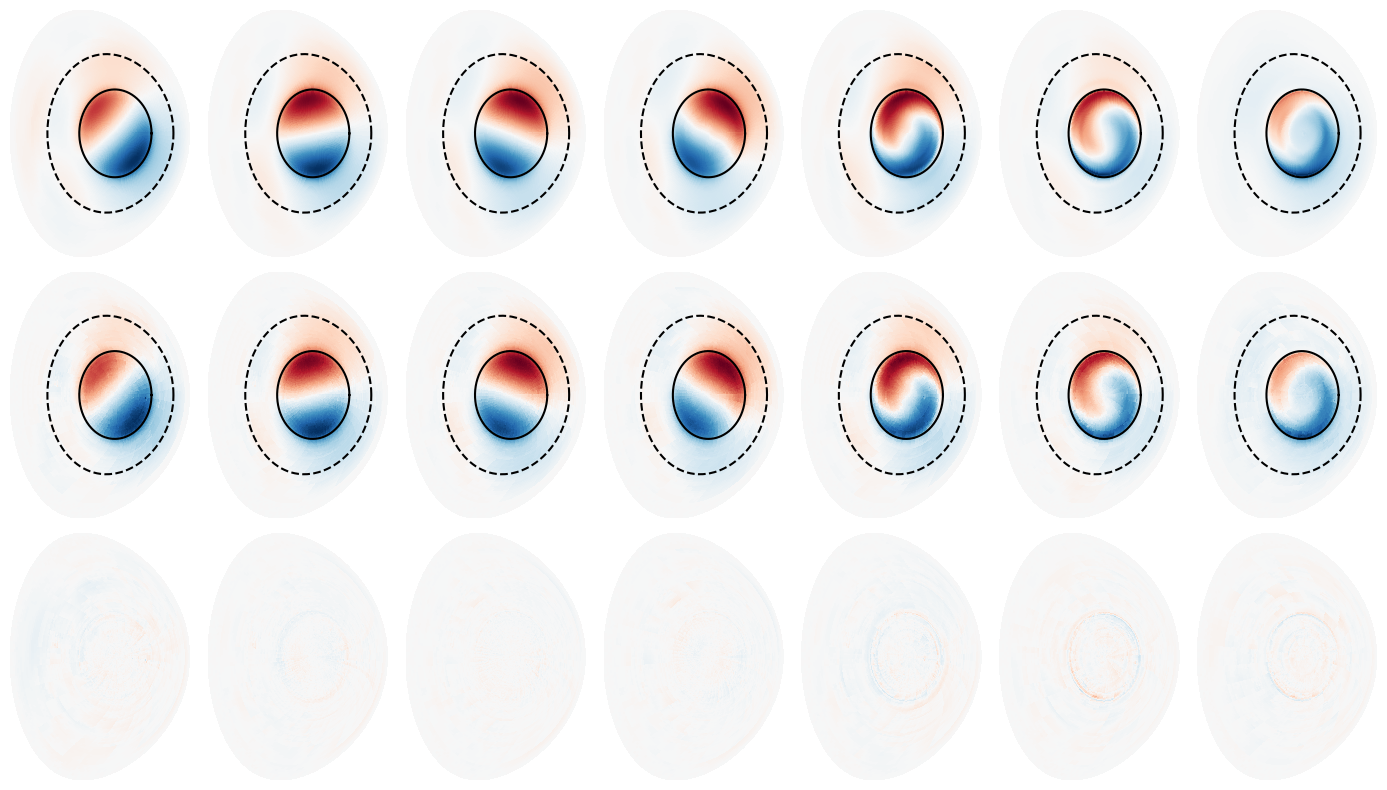

CPU times: user 33.6 s, sys: 1min 49s, total: 2min 23s
Wall time: 19.1 s


In [3]:
%%time
# network parameters
num_epochs = 200
lr = 0.001
best_loss = 1
best_epoch = -1
early_stop_thresh = 20
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-06)
epoch_loss = {'train_loss':[],'val_loss':[]}
# one instance
for ri in range(1):
    for epoch in range(num_epochs):
        train_loss =train_epoch(encoder, decoder, device, train_loader, loss_fn, optim)
        val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
        print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
        print('\n EPOCH {}/{} \t val loss {}'.format(epoch + 1, num_epochs,val_loss))
        epoch_loss['train_loss'].append(train_loss)
        epoch_loss['val_loss'].append(val_loss)
        if epoch % 100 == 0 or epoch == num_epochs-1:
            plot_ae_outputs(PhiT, X, Z, device, encoder, decoder, epoch, n=7, i_seq=[9, 51, 86, 111, 129, 144, 159])
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            checkpoint(encoder, "best_encoder_model.pth")
            checkpoint(decoder, "best_decoder_model.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop

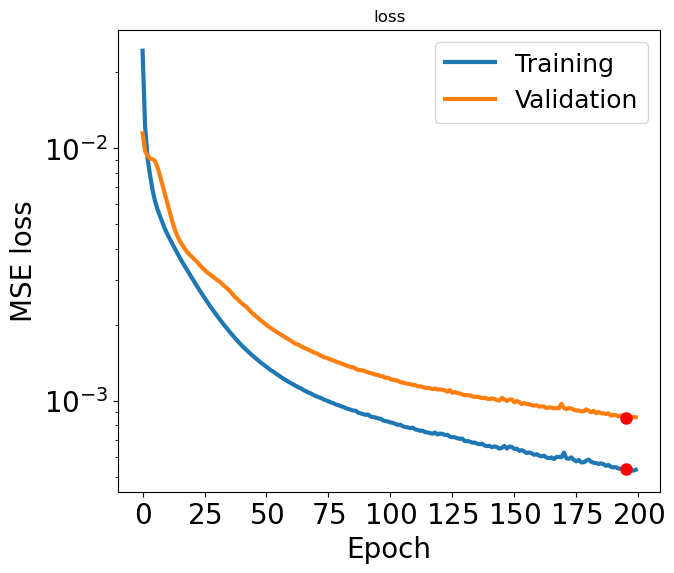

<Figure size 640x480 with 0 Axes>

In [4]:
## plot loss 
fig = plt.figure(figsize=(7,6))
plt.semilogy(epoch_loss['train_loss'],linewidth=3,label='Training')
plt.semilogy(epoch_loss['val_loss'], linewidth=3,label='Validation')
plt.semilogy(best_epoch, epoch_loss['train_loss'][best_epoch], 'ro', linewidth=2, markersize=8)
plt.semilogy(best_epoch, epoch_loss['val_loss'][best_epoch], 'ro', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('MSE loss', fontsize = 20)
plt.yticks([0.001,0.01], fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
plt.legend(fontsize = 18)
plt.grid()
plt.title('loss')
plt.show()
plt.tight_layout()
fig.savefig('./train_val_loss.png')